## Imports

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import os
import matplotlib.pyplot as plt

from utilities import grouped_apply_agg, is_payday

%matplotlib widget

## Importing data

In [2]:
data_dir = "data"

info_db = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col=0)
store_db = pd.read_csv(os.path.join(data_dir, "stores.csv"), index_col=0)
oil_db = pd.read_csv(os.path.join(data_dir, "oil.csv"))

holidays_db = pd.read_csv(os.path.join(data_dir, "holidays_events.csv"))

local_holidays_db = holidays_db[holidays_db['locale'] == 'Local']
local_holidays_db = holidays_db.rename(columns={'locale_name': 'city', 'type': 'h_type_loc', 'description': 'h_description_loc', 'transferred': 'h_transferred_loc'})
local_holidays_db = local_holidays_db.drop(columns=['locale'])
local_holidays_db = local_holidays_db.groupby(['date']).first().reset_index()

national_holidays_db = holidays_db[holidays_db['locale'] == 'National']
national_holidays_db = national_holidays_db.rename(columns={'type': 'h_type_nat', 'description': 'h_description_nat', 'transferred': 'h_transferred_nat'})
national_holidays_db = national_holidays_db.drop(columns=['locale', 'locale_name'])
national_holidays_db = national_holidays_db.groupby(['date']).first().reset_index()


transactions_db = pd.read_csv(os.path.join(data_dir, "transactions.csv"))

db = info_db.merge(store_db, on="store_nbr", how="left")

db = db.merge(oil_db, on="date", how="left")
db['dcoilwtico'] = db['dcoilwtico'].fillna(method='bfill')

db = db.merge(national_holidays_db, on="date", how="left")
db['h_type_nat'] = db['h_type_nat'].fillna('no_holiday')
db['h_description_nat'] = db['h_description_nat'].fillna('no_holiday')
db['h_transferred_nat'] = db['h_transferred_nat'].fillna('no_holiday')

db = db.merge(local_holidays_db, on=["date", 'city'], how="left")
db['h_type_loc'] = db['h_type_loc'].fillna('no_holiday')
db['h_description_loc'] = db['h_description_loc'].fillna('no_holiday')
db['h_transferred_loc'] = db['h_transferred_loc'].fillna('no_holiday')

db = db.merge(transactions_db, on=["date", "store_nbr"], how="left")
db['transactions'] = db['transactions'].fillna(0)

db['date'] = pd.to_datetime(db['date'])

db['year'] = pd.to_datetime(db['date']).dt.year
db['month'] = pd.to_datetime(db['date']).dt.month
db['day'] = pd.to_datetime(db['date']).dt.day
db['day_of_week'] = db['date'].dt.dayofweek

db = db[db['date'] >= '2013-02-01']

group = ['family', 'day_of_week', 'store_nbr']
cols = ['sales', 'transactions']
names = ['dow_avg', 'dow_rolling_1', 'dow_rolling_3', 'dow_rolling_7']
agg_funcs = [
    lambda x: x.expanding().mean().shift(1).fillna(0),
    lambda x: x.rolling(window=1).mean().shift(1).fillna(0),
    lambda x: x.rolling(window=3).mean().shift(1).fillna(0),
    lambda x: x.rolling(window=7).mean().shift(1).fillna(0),
]
dow_aves_db = grouped_apply_agg(
    db[['date', 'store_nbr', 'transactions', 'family', 'sales', 'day_of_week']].copy(),
    group,
    cols, 
    names, 
    agg_funcs
).drop(columns=['sales', 'transactions', 'day_of_week'])

db = db.merge(dow_aves_db, on=['date','store_nbr', 'family'], how='left')

group = ['family', 'store_nbr']
cols = ['sales', 'transactions']
names = ['prev_1', 'prev_7', 'prev_14']
agg_funcs = [
    lambda x: x.shift(1).fillna(0),
    lambda x: x.shift(7).fillna(0),
    lambda x: x.shift(14).fillna(0),
]
rolling_db = grouped_apply_agg(
    db[['date', 'store_nbr', 'transactions', 'family', 'sales']].copy(),
    group,
    cols, 
    names, 
    agg_funcs
).drop(columns=['sales', 'transactions'])

db = db.merge(rolling_db, on=['date','store_nbr', 'family'], how='left')

db['is_payday'] = db['date'].apply(is_payday)
db['is_earth_quake'] = (db['date'] >= '2016-04-16') & (db['date'] < '2016-05-01')
db['is_weekday'] = db['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
db['is_weekend'] = db['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

db = db.sort_index()

In [5]:
display(db.head(20))
display(db.info())

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,oil,...,prev_1_sales,prev_7_sales,prev_14_sales,prev_1_transactions,prev_7_transactions,prev_14_transactions,is_payday,is_earth_quake,is_weekday,is_weekend
0,2013-02-01,1,0,3.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
1,2013-02-01,1,1,0.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
2,2013-02-01,1,2,0.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
3,2013-02-01,1,3,941.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
4,2013-02-01,1,4,0.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
5,2013-02-01,1,5,318.274,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
6,2013-02-01,1,6,0.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
7,2013-02-01,1,7,739.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
8,2013-02-01,1,8,430.000,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0
9,2013-02-01,1,9,122.340,0,0,0,0,13,97.46,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945646 entries, 0 to 2945645
Data columns (total 39 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   store_nbr                   int64         
 2   family                      int64         
 3   sales                       float64       
 4   onpromotion                 int64         
 5   city                        int64         
 6   state                       int64         
 7   store_type                  int64         
 8   cluster                     int64         
 9   oil                         float64       
 10  h_type_nat                  int64         
 11  h_description_nat           int64         
 12  h_transferred_nat           int64         
 13  h_type_loc                  int64         
 14  h_description_loc           int64         
 15  h_transferred_loc           int64         
 16  transactions      

None

## Renaming and Assigning classes

In [4]:
col_rename = {
    'dcoilwtico': 'oil',
    'type': 'store_type',
}

db = db.rename(columns=col_rename)

col_str_to_class_label = {}

for col in db.columns:
    # skip if the column is numeric
    if is_numeric_dtype(db[col]):
        continue
    elif col == 'date':
        continue
    str_to_class = {}
    for i, val in enumerate(db[col].unique()):
        str_to_class[val] = i
    col_str_to_class_label[col] = str_to_class

for col, dict in col_str_to_class_label.items():
    db[col] = db[col].map(dict)

display(db.tail())

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,oil,...,prev_1_sales,prev_7_sales,prev_14_sales,prev_1_transactions,prev_7_transactions,prev_14_transactions,is_payday,is_earth_quake,is_weekday,is_weekend
2945641,2017-08-15,9,28,438.133,0,0,0,2,6,47.57,...,283.429,358.132,570.196000,1971.0,2035.0,2271.0,True,False,1,0
2945642,2017-08-15,9,29,154.553,1,0,0,2,6,47.57,...,114.120,112.954,50.462997,1971.0,2035.0,2271.0,True,False,1,0
2945643,2017-08-15,9,30,2419.729,148,0,0,2,6,47.57,...,1348.425,2299.715,2470.461000,1971.0,2035.0,2271.0,True,False,1,0
2945644,2017-08-15,9,31,121.000,8,0,0,2,6,47.57,...,182.000,170.000,203.000000,1971.0,2035.0,2271.0,True,False,1,0
2945645,2017-08-15,9,32,16.000,0,0,0,2,6,47.57,...,17.000,15.678,19.316000,1971.0,2035.0,2271.0,True,False,1,0


## Calculating Correlation

In [7]:
rows = [
    'sales',
    'transactions',
    'store_nbr',
    'family',
    'city',
    'state',
    'store_type',
    'cluster',
    'oil',
    'month',
    'day',
    'h_type_nat',
    'h_type_loc',
    'dow_avg_sales',
    'dow_rolling_1_sales',
    'dow_rolling_3_sales',
    'dow_rolling_7_sales',
    'prev_1_sales',
    'prev_7_sales',
    'prev_14_sales',
    'dow_avg_transactions',
    'dow_rolling_1_transactions',
    'dow_rolling_3_transactions',
    'dow_rolling_7_transactions',
    'prev_1_transactions',
    'prev_7_transactions',
    'prev_14_transactions',
    'is_payday',
    'is_earth_quake',
    'is_weekday',
    'is_weekend',
]

cov_db = db[rows].copy()
for col in cov_db.columns:
    cov_db[col] = cov_db[col].astype(np.float32)

cov_matrix = cov_db.corr()

display(cov_matrix)

del cov_db

,sales,transactions,store_nbr,family,city,state,store_type,cluster,oil,month,...,dow_rolling_1_transactions,dow_rolling_3_transactions,dow_rolling_7_transactions,prev_1_transactions,prev_7_transactions,prev_14_transactions,is_payday,is_earth_quake,is_weekday,is_weekend
sales,1.000000,2.328793e-01,4.148249e-02,-1.139510e-01,-9.680985e-02,-9.927258e-02,1.005338e-01,3.857158e-02,-7.298275e-02,1.572191e-02,...,2.208178e-01,2.233816e-01,2.223873e-01,2.159989e-01,2.194415e-01,2.197048e-01,1.253574e-03,1.401412e-02,-5.168948e-02,5.168948e-02
transactions,0.232879,1.000000e+00,1.099183e-01,1.255363e-15,-4.614937e-01,-4.688735e-01,3.874150e-01,1.877146e-01,-4.926910e-02,4.305063e-02,...,9.429583e-01,9.381907e-01,9.150858e-01,9.322616e-01,9.362942e-01,9.224255e-01,8.506252e-03,8.715341e-03,-1.143916e-01,1.143916e-01
store_nbr,0.041482,1.099183e-01,1.000000e+00,4.869794e-18,5.886759e-01,5.874486e-01,5.719704e-01,-5.928399e-02,3.477547e-15,-4.433827e-15,...,1.085770e-01,1.087874e-01,1.065230e-01,1.097629e-01,1.085770e-01,1.073148e-01,-1.245058e-16,-6.207153e-16,6.171251e-18,-3.225259e-17
family,-0.113951,1.255363e-15,4.869794e-18,1.000000e+00,-1.801533e-20,7.083598e-19,2.097972e-18,4.120518e-19,-2.789456e-14,8.949784e-15,...,1.417881e-15,1.760395e-15,2.348967e-15,1.279617e-15,1.416074e-15,1.596503e-15,-2.336484e-17,1.934651e-15,-5.292381e-18,5.256718e-18
city,-0.096810,-4.614937e-01,5.886759e-01,-1.801533e-20,1.000000e+00,9.852099e-01,-1.113357e-01,-4.230199e-01,2.586724e-15,5.014741e-16,...,-4.585977e-01,-4.607877e-01,-4.526882e-01,-4.610523e-01,-4.585977e-01,-4.556667e-01,-1.600465e-17,6.811365e-16,-4.967484e-17,3.649097e-17
state,-0.099273,-4.688735e-01,5.874486e-01,7.083598e-19,9.852099e-01,1.000000e+00,-1.073820e-01,-4.167306e-01,-2.768584e-14,7.551043e-16,...,-4.659416e-01,-4.682326e-01,-4.601252e-01,-4.684260e-01,-4.659416e-01,-4.629618e-01,1.655833e-16,2.905835e-15,3.398775e-17,-4.498256e-17
store_type,0.100534,3.874150e-01,5.719704e-01,2.097972e-18,-1.113357e-01,-1.073820e-01,1.000000e+00,3.880565e-01,1.646692e-14,-2.966056e-15,...,3.840897e-01,3.854589e-01,3.780955e-01,3.869464e-01,3.840897e-01,3.808094e-01,-2.970615e-17,1.300231e-15,4.917493e-19,-6.960933e-18
cluster,0.038572,1.877146e-01,-5.928399e-02,4.120518e-19,-4.230199e-01,-4.167306e-01,3.880565e-01,1.000000e+00,-3.428183e-14,2.914834e-15,...,1.863618e-01,1.872026e-01,1.838625e-01,1.875070e-01,1.863618e-01,1.849645e-01,8.789969e-17,1.433102e-15,-7.971094e-18,1.502847e-17
oil,-0.072983,-4.926910e-02,3.477547e-15,-2.789456e-14,2.586724e-15,-2.768584e-14,1.646692e-14,-3.428183e-14,1.000000e+00,4.129520e-02,...,-5.601561e-02,-7.185831e-02,-9.492090e-02,-5.034744e-02,-5.614606e-02,-6.406058e-02,-1.864987e-03,-9.243813e-02,4.294799e-04,-4.294799e-04
month,0.015722,4.305063e-02,-4.433827e-15,8.949784e-15,5.014741e-16,7.551043e-16,-2.966056e-15,2.914834e-15,4.129520e-02,1.000000e+00,...,2.401905e-02,6.003687e-03,1.785814e-02,3.809511e-02,1.588263e-02,-1.462848e-02,-9.486445e-04,-6.604373e-02,2.606041e-03,-2.606041e-03


## Plotting Some EDA

## Plotting raw sales for each store by family

/home/codygrogan/.local/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/codygrogan/.local/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


Autocorr: 0.5003178513904764 Pearson: 0.13802977367449812


/tmp/ipykernel_12692/2543843470.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


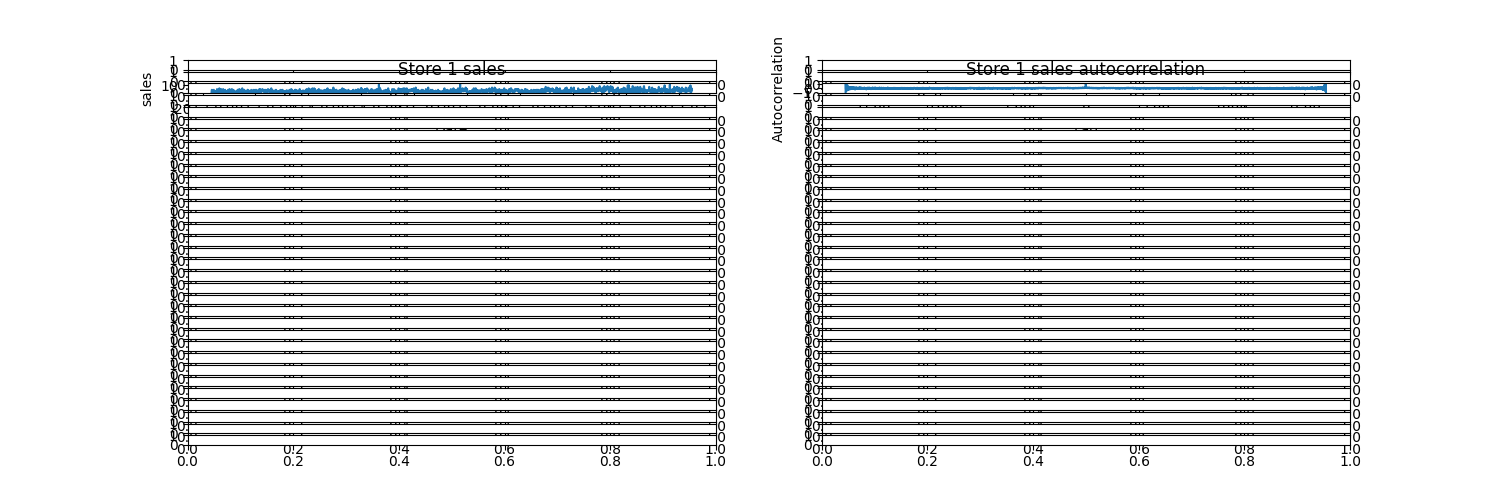

In [8]:
store_no = 1
store_db = db[db['store_nbr'] == store_no]

fig, axs = plt.subplots(store_db['family'].nunique(), 2, figsize=(15,5))

#families = store_db['family'].nunique()
families = [2]

for i in families:
    ax0 = axs[i, 0]
    ax1 = axs[i, 1]

    fam_db = store_db[store_db['family'] == i]
    
    ax0.plot(fam_db['date'], fam_db['sales'], label=f"Family {i}")
    ax0.set_title(f"Store {store_no} sales")
    ax0.set_xlabel("Date")
    ax0.set_ylabel("sales")

    sales = fam_db['sales']
    lags = []
    auto_corr = []
    for lag in range(-len(sales)+1, len(sales)):
        lags.append(lag)
        auto_corr.append(sales.autocorr(lag=lag))

    
    sales_lag1 = sales.shift(1).fillna(0)

    auto_c = ((sales-sales.mean()) * (sales_lag1 - sales_lag1.mean())).mean()
    print(f"Autocorr: {auto_c} Pearson: {auto_c / (sales.std() * sales_lag1.std())}")

    
    ax1.plot(lags, auto_corr, label=f"Family {i}")
    ax1.set_title(f"Store {store_no} sales autocorrelation")
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Autocorrelation")

fig.tight_layout()
plt.show()


## Saving Data

In [9]:
db.to_csv(os.path.join(data_dir, "train_data.csv"), index=False)

## Making Test Data Set

In [6]:
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"), index_col=0)
index_col = test_df.index

test_df = test_df.merge(store_db, on="store_nbr", how="left")
test_df = test_df.merge(oil_db, on="date", how="left")
test_df['dcoilwtico'] = test_df['dcoilwtico'].fillna(method='bfill')


test_df = test_df.merge(national_holidays_db, on="date", how="left")
test_df['h_type_nat'] = test_df['h_type_nat'].fillna('no_holiday')
test_df['h_description_nat'] = test_df['h_description_nat'].fillna('no_holiday')
test_df['h_transferred_nat'] = test_df['h_transferred_nat'].fillna('no_holiday')

test_df = test_df.merge(local_holidays_db, on=["date", 'city'], how="left")
test_df['h_type_loc'] = test_df['h_type_loc'].fillna('no_holiday')
test_df['h_description_loc'] = test_df['h_description_loc'].fillna('no_holiday')
test_df['h_transferred_loc'] = test_df['h_transferred_loc'].fillna('no_holiday')


test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = pd.to_datetime(test_df['date']).dt.year
test_df['month'] = pd.to_datetime(test_df['date']).dt.month
test_df['day'] = pd.to_datetime(test_df['date']).dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek

test_df = test_df.rename(columns=col_rename)

display(test_df.head())

for col, dict in col_str_to_class_label.items():
    print(col, dict)
    test_df[col] = test_df[col].map(dict)

most_recent_dow_aves = db.groupby(['store_nbr', 'family', 'day_of_week']).tail(1)

del db

most_recent_dow_aves = most_recent_dow_aves[
    ['store_nbr', 'family', 'day_of_week', 'dow_avg_sales', 'dow_rolling_1_sales',
    'dow_rolling_3_sales', 'dow_rolling_7_sales', 'prev_1_sales', 'prev_7_sales',
    'prev_14_sales', 'dow_avg_transactions', 'dow_rolling_1_transactions', 'dow_rolling_3_transactions',
    'dow_rolling_7_transactions', 'prev_1_transactions', 'prev_7_transactions', 'prev_14_transactions']]

test_df = test_df.merge(most_recent_dow_aves, on=['store_nbr', 'family', 'day_of_week'], how='left')

test_df['is_payday'] = test_df['date'].apply(is_payday)
test_df['is_earth_quake'] = (test_df['date'] >= '2016-04-16') & (test_df['date'] < '2016-05-01')
test_df['is_weekday'] = test_df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
test_df['is_weekend'] = test_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

test_df = test_df.drop(columns=["date"])
test_df.index = index_col



display(test_df.head())



,date,store_nbr,family,onpromotion,city,state,store_type,cluster,oil,h_type_nat,h_description_nat,h_transferred_nat,h_type_loc,h_description_loc,h_transferred_loc,year,month,day,day_of_week
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,2017,8,16,2
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,2017,8,16,2
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,2017,8,16,2
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,2017,8,16,2
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,no_holiday,2017,8,16,2


family {'AUTOMOTIVE': 0, 'BABY CARE': 1, 'BEAUTY': 2, 'BEVERAGES': 3, 'BOOKS': 4, 'BREAD/BAKERY': 5, 'CELEBRATION': 6, 'CLEANING': 7, 'DAIRY': 8, 'DELI': 9, 'EGGS': 10, 'FROZEN FOODS': 11, 'GROCERY I': 12, 'GROCERY II': 13, 'HARDWARE': 14, 'HOME AND KITCHEN I': 15, 'HOME AND KITCHEN II': 16, 'HOME APPLIANCES': 17, 'HOME CARE': 18, 'LADIESWEAR': 19, 'LAWN AND GARDEN': 20, 'LINGERIE': 21, 'LIQUOR,WINE,BEER': 22, 'MAGAZINES': 23, 'MEATS': 24, 'PERSONAL CARE': 25, 'PET SUPPLIES': 26, 'PLAYERS AND ELECTRONICS': 27, 'POULTRY': 28, 'PREPARED FOODS': 29, 'PRODUCE': 30, 'SCHOOL AND OFFICE SUPPLIES': 31, 'SEAFOOD': 32}
city {'Quito': 0, 'Cayambe': 1, 'Latacunga': 2, 'Riobamba': 3, 'Ibarra': 4, 'Santo Domingo': 5, 'Guaranda': 6, 'Puyo': 7, 'Ambato': 8, 'Guayaquil': 9, 'Salinas': 10, 'Daule': 11, 'Babahoyo': 12, 'Quevedo': 13, 'Playas': 14, 'Libertad': 15, 'Cuenca': 16, 'Loja': 17, 'Machala': 18, 'Esmeraldas': 19, 'Manta': 20, 'El Carmen': 21}
state {'Pichincha': 0, 'Cotopaxi': 1, 'Chimborazo': 2,

,store_nbr,family,onpromotion,city,state,store_type,cluster,oil,h_type_nat,h_description_nat,...,dow_rolling_1_transactions,dow_rolling_3_transactions,dow_rolling_7_transactions,prev_1_transactions,prev_7_transactions,prev_14_transactions,is_payday,is_earth_quake,is_weekday,is_weekend
id,,,,,,,,,,,,,,,,,,,,,
3000888,1,0,0,0,0,0,13,46.8,0,0,...,1892.0,1864.0,1888.857143,1766.0,1892.0,1903.0,False,False,1,0
3000889,1,1,0,0,0,0,13,46.8,0,0,...,1892.0,1864.0,1888.857143,1766.0,1892.0,1903.0,False,False,1,0
3000890,1,2,2,0,0,0,13,46.8,0,0,...,1892.0,1864.0,1888.857143,1766.0,1892.0,1903.0,False,False,1,0
3000891,1,3,20,0,0,0,13,46.8,0,0,...,1892.0,1864.0,1888.857143,1766.0,1892.0,1903.0,False,False,1,0
3000892,1,4,0,0,0,0,13,46.8,0,0,...,1892.0,1864.0,1888.857143,1766.0,1892.0,1903.0,False,False,1,0


In [7]:
test_df.to_csv(os.path.join(data_dir, "test_data.csv"), index=True)